# FIT5149 - Applied Data Analysis: Assignment 1 (Monthly Stock Prediction: EDA)

This notebook focuses on the EDA of the monthly stock prediction task, where the goal is to predict whether a stock will achieve a positive or negative excess return (`outperform_binary`) and the continuous excesss return value (`excess_return`).

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

from scipy.stats import pearsonr, ttest_ind

## 1. Loading Data

Our dataset is made up of several key components, grouped into core data and optional macroeconomic data.

### Core Data
1. `stock_data.csv`: Historical monthly stock-level data.

2. `company_info.csv`: Company profile information, including sector, business model, business maturity, market cap category, revenue tier, and other attributes that describe each company.

3. `monashIndex.csv`: A benchmark index (similar to the S&P 500). For example, the excess_return label in our regression task is derived from the index_return column in this dataset.

4. `training_targets.csv`: Ground-truth labels for training. It contains:
- `outperform_binary`: For the classification task.
- `excess_return`: For the regression task.

5. `testing_targets.csv`: Similar to the training targets, but used for model evaluation and submission.

### Macroeconomic Data
1. `fed_funds_rate.csv`: The interest rate at which banks lend reserves to each other overnight.

2. `fed_inflation_rate.csv`: Measures the pace of price increases in the economy (commonly via CPI).

3. `fed_unemployment_rate.csv`: Percentage of the labor force that is unemployed but actively seeking work.

4. `us_5_year_treasury.csv`: Mid-term government bond yield, often compared against the 10-year rate.

5. `us_10_year_treasury.csv`: Long-term government bond yield, commonly treated as the benchmark “risk-free rate.”

6. `vix_index.csv`: A measure of expected near-term market volatility, derived from S&P 500 options (often referred to as the “fear index”).

In [2]:
def load_data(data_dir="../data"):
    # Primary data
    primary_data_dir = Path(data_dir)
    stock = pd.read_csv(primary_data_dir/"stock_data.csv")
    company = pd.read_csv(primary_data_dir/"company_info.csv")
    index = pd.read_csv(primary_data_dir/"monashIndex.csv")
    train_targets = pd.read_csv(primary_data_dir/"training_targets.csv")

    # Optional data
    optional_data_dir = primary_data_dir/"optional_data"
    optional_data_list = []
    for fname in optional_data_dir.glob("*.csv"):
        optional_data_list.append(pd.read_csv(fname))
    
    return stock, company, index, train_targets, optional_data_list

In [3]:
stock, company, index, train_targets, optional_data_list = load_data()

In [4]:
stock.head()

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,-0.075676,0.253304,0.278396,0.201608,21,3182487.0,1.207,0.136875
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,-0.060752,0.259208,0.245523,0.192782,19,3686371.0,1.126,0.110905
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,-0.154874,0.892709,0.088364,0.213051,22,5360363.0,1.509,0.268931
3,US001,2020_04,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,-0.033810,-0.062835,0.408352,0.366808,0.291241,21,5571115.0,0.803,0.242954
4,US001,2020_05,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,0.058641,-0.060951,0.419368,0.347233,0.292040,20,5753938.0,0.817,0.203186


In [5]:
company.head()

,stock_id,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,US001,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,US002,Industrials,B2B,Global,Growth,Strong_Player,Mid,Tier_2,Standard,Capital_Intensive,Stable
2,US003,Healthcare,B2C,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Stable
3,US004,Healthcare,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Asset_Light,Strong
4,US005,Technology,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Strong


In [6]:
index.head()

,month_id,index_return,index_value
0,2020_01,-0.006452,99.354842
1,2020_02,-0.053054,94.083684
2,2020_03,-0.111379,83.604709
3,2020_04,0.141313,95.419099
4,2020_05,0.071232,102.215965


In [7]:
train_targets.head()

,month_id,stock_id,outperform_binary,excess_return
0,2020_01,US001,0,-0.100593
1,2020_02,US001,0,-0.005920
2,2020_03,US001,1,0.013384
3,2020_04,US001,1,0.009597
4,2020_05,US001,0,-0.013023


In [8]:
len(optional_data_list)

6

## 2. Data Merging

Once we have the data loaded, we need to join (merge) them together under one table so that all features including the training labels. 

In [9]:
def merge_data(stock, company, index, train_targets, optional_data_list=None):
    # Merge/join the primary data
    df = pd.merge(stock, company, on=["stock_id"], how="left")
    df = pd.merge(df, index, on=["month_id"], how="left")
    df = pd.merge(df, train_targets, on=["month_id", "stock_id"], how="left")

    # Optionally merge the optional data
    if optional_data_list:
        for optional_data in optional_data_list:
            df = pd.merge(df, optional_data, on=["month_id"], how="left")
    
    return df

In [10]:
df_without_optional_features = merge_data(stock, company, index, train_targets)
df_without_optional_features.head(3)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength,index_return,index_value,outperform_binary,excess_return
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.006452,99.354842,0,-0.100593
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.053054,94.083684,0,-0.005920
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.111379,83.604709,1,0.013384


Notice that we have 6 additional attributes when including the optional features.

In [11]:
df_with_optional_features = merge_data(stock, company, index, train_targets, optional_data_list)
df_with_optional_features.head(3)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,index_return,index_value,outperform_binary,excess_return,fed_rate,inflation_rate,unemployment_rate,10y_treasury,5y_treasury,vix
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,...,-0.006452,99.354842,0,-0.100593,1.55,2.599768,3.6,1.52,1.33,13.94
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,...,-0.053054,94.083684,0,-0.005920,1.58,2.341317,3.5,1.13,0.91,19.63
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,...,-0.111379,83.604709,1,0.013384,0.65,1.494040,4.4,0.70,0.38,57.74


## Missing Values

Let's do some basic checks with checking the missing values for each column.

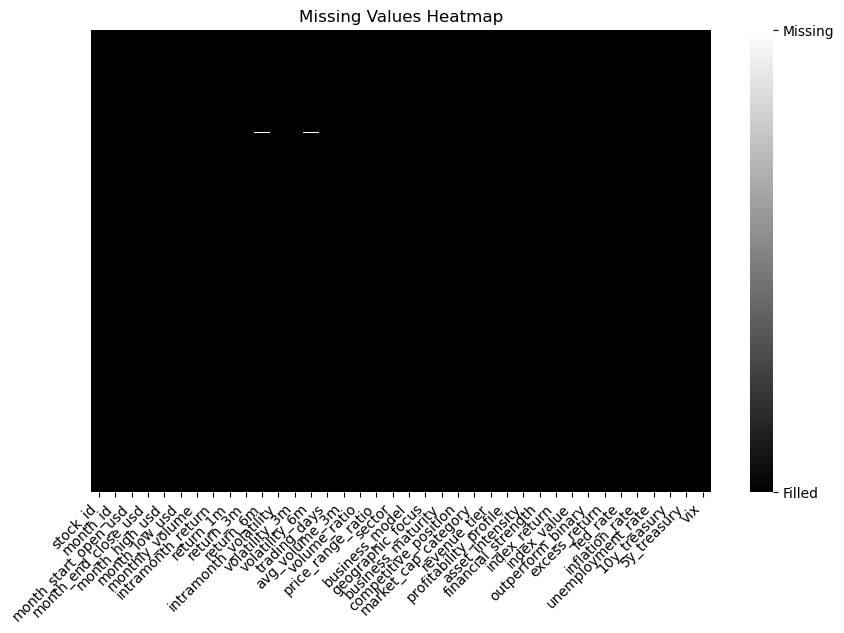

In [12]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(
    df_with_optional_features.isnull(),
    cbar=True,
    cmap="binary_r",   # black = 1 (missing), white = 0 (filled)
    cbar_kws={'ticks':[1,0]}
)

# Set titles and ticks
plt.title("Missing Values Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks([])

# Customize colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(["Missing", "Filled"])

plt.show()

In [13]:
null_df = df_with_optional_features.isnull().sum().to_frame(name="missing_count")
null_df["missing_count_pct"] = null_df["missing_count"] / len(df_with_optional_features) * 100
null_df.query("missing_count > 0")

,missing_count,missing_count_pct
return_1m,21,0.081974
return_3m,63,0.245921
return_6m,135,0.526973
intramonth_volatility,2,0.007807
volatility_3m,63,0.245921
volatility_6m,135,0.526973
avg_volume_3m,42,0.163947
volume_ratio,42,0.163947


There are only small portion of missing values in the data. However, imputing them with the correct method might actually help the model to capture important patterns. We can compare between three common imputation techniques:

1. Median
2. Forward (or backward) fill
3. KNN

C:\Users\Archel\AppData\Local\Temp\ipykernel_34852\1622416897.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ffill_vals = df_before.fillna(method="ffill")


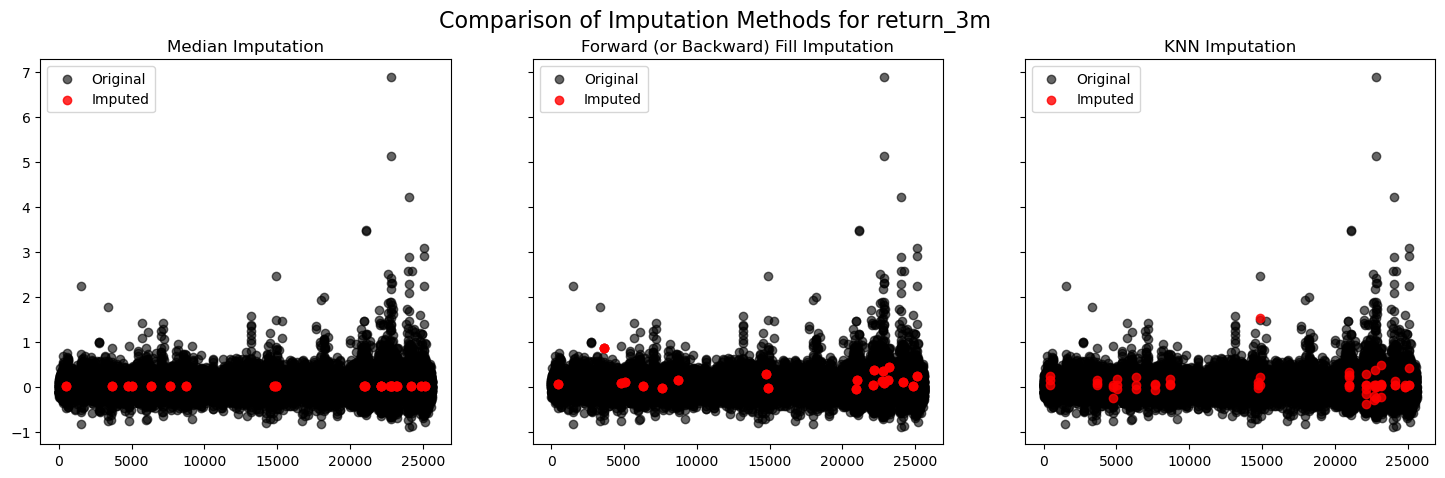

In [14]:
feature = "return_3m"
df_before = df_with_optional_features[[feature]].copy()

# Median imputation
median_vals = df_before.fillna(df_before[feature].median())
# Forward-fill imputation
ffill_vals = df_before.fillna(method="ffill")
# KNN imputation (example: using return_1m, return_3m, return_6m)
imputer = KNNImputer(n_neighbors=5)
knn_imputed_array = imputer.fit_transform(df_with_optional_features[["return_1m", "return_3m", "return_6m"]])
df_knn = pd.DataFrame(knn_imputed_array, columns=["return_1m", "return_3m", "return_6m"])
knn_vals = df_knn[feature]

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

# Median
axes[0].scatter(df_before.index, df_before[feature], color="black", alpha=0.6, label="Original")
axes[0].scatter(df_before.index[df_before[feature].isna()],
                median_vals[feature][df_before[feature].isna()],
                color="red", alpha=0.8, label="Imputed")
axes[0].set_title("Median Imputation")
axes[0].legend()

# Forward-fill
axes[1].scatter(df_before.index, df_before[feature], color="black", alpha=0.6, label="Original")
axes[1].scatter(df_before.index[df_before[feature].isna()],
                ffill_vals[feature][df_before[feature].isna()],
                color="red", alpha=0.8, label="Imputed")
axes[1].set_title("Forward (or Backward) Fill Imputation")
axes[1].legend()

# 3. KNN
axes[2].scatter(df_before.index, df_before[feature], color="black", alpha=0.6, label="Original")
axes[2].scatter(df_before.index[df_before[feature].isna()],
                knn_vals[df_before[feature].isna()],
                color="red", alpha=0.8, label="Imputed")
axes[2].set_title("KNN Imputation")
axes[2].legend()

plt.suptitle(f"Comparison of Imputation Methods for {feature}", fontsize=16)
plt.show()


The forward fill and KNN imputation methods perform better as they add certain noise into the imputed values as opposed to only constants (median). Thus, we can proceed with imputing them with forward (or backward) fill or KNN.

In [15]:
def impute_missing_columns(df, method, columns_to_impute):
    for column in columns_to_impute:
        if method == "forward_fill":
            df[column] = df[column].fillna(method="ffill")
        elif method == "median":
            df[column] = df[column].fillna(df[column].median())
    
    return df

In [16]:
columns_to_impute = null_df.index
df_clean = impute_missing_columns(df_with_optional_features, method="forward_fill", columns_to_impute=columns_to_impute)

C:\Users\Archel\AppData\Local\Temp\ipykernel_34852\255450723.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")


## EDA

Once we have filled the missing values, now we can proceed with the EDA.

In [17]:
def show_distribution_plot_categorical(df, feature):
    dist_count_df = df[feature].value_counts().to_frame().reset_index()
    
    plt.figure(figsize=(8,6))
    sns.barplot(x=feature, y="count", data=dist_count_df)
    plt.title(f"{feature} Class Distribution")
    plt.xticks(rotation=35, ha="right")

def show_distribution_plot_numerical(df, feature):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    sns.histplot(x=feature, data=df, ax=axes[0])
    axes[0].set_title(f"{feature} Histgoram Plot")

    sns.boxplot(y=feature, data=df, ax=axes[1])
    axes[1].set_title(f"{feature} Boxplot")

Perhaps the most important analysis to look at is the label class distribution `outperform_binary` and `excess_return`

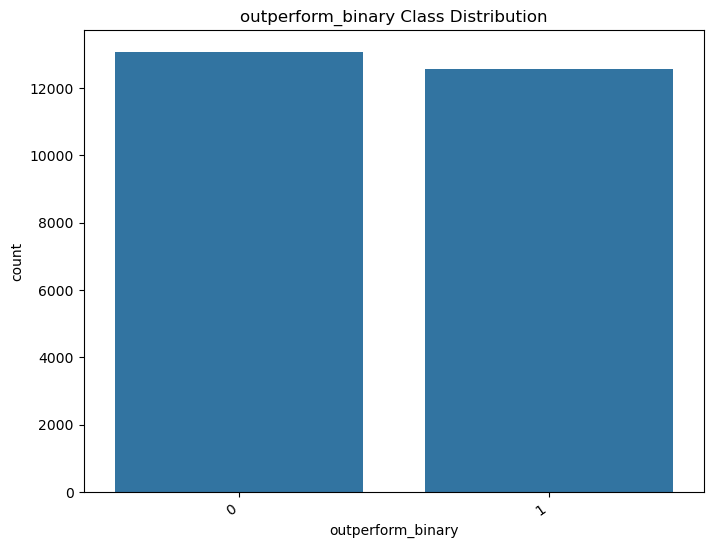

In [18]:
show_distribution_plot_categorical(df_clean, "outperform_binary")

The `outperform_binary` class distribution is even between class `0` and `1`. This means that we would not need to worry about class imbalance problem during training.

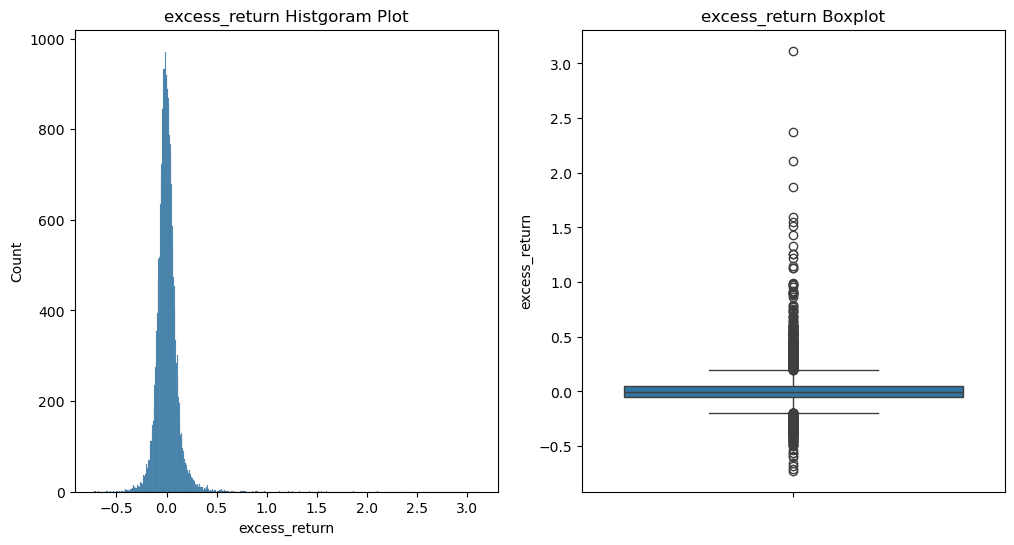

In [19]:
show_distribution_plot_numerical(df_clean, "excess_return")

The `excess_return` distribution also follows a normal distribution, which is great. We can expect our models will also have a normal distribution with mean around 0.0 and standard deviation around 0.25.

In [20]:
categorical_features = [column for column in df_clean.columns if df_clean[column].dtype == "O" and column not in ["stock_id", "month_id"]]
numerical_features = [column for column in df_clean.columns if df_clean[column].dtype == "float64" or df_clean[column].dtype == "int64" and column not in ["outperform_binary", "excess_return"]]

Next, we can show the distribution for the rest of the attributes. One thing to note is that we can split the categorical features further into nominal and ordinal features.

- Categorical: `sector` and `business_model`.
- Ordinal: `geographic_focus`, `business_maturity`, `competitive_position`, `market_cap_category`, `revenue_tier`, `profitability_profile`, `asset_intensity`, and `financial_strength`.

With categorical features, groups or labels lack mathematical meaning. For example, the `sector` classes below do not have a meaningful order. We cannot say that "Technology" is a higher hierarchy than "Finance".

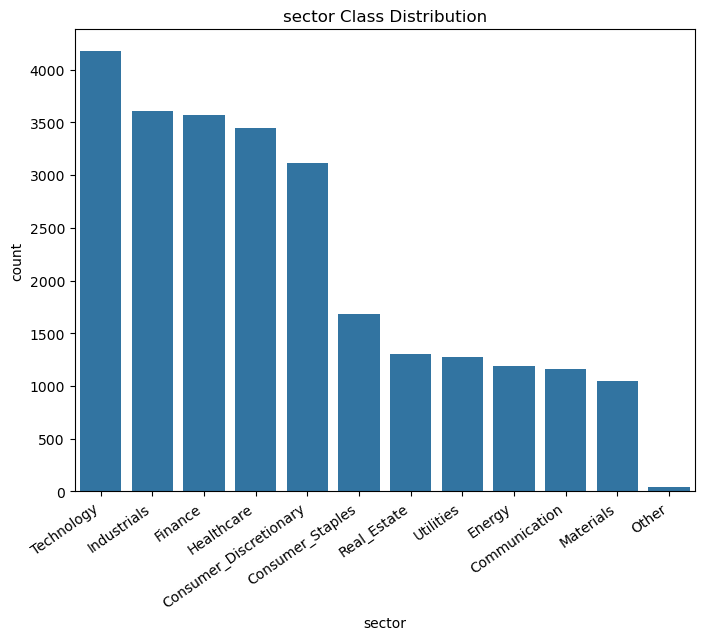

In [21]:
show_distribution_plot_categorical(df_clean, "sector")

Meanwhile, we can assume mathematical ordering on the `business_maturity` attribute. "Mature" businesses have a higher rank compared to "Growth" and "Cyclical" businesses and "Growth" is a higher rank than "Cyclical" business.

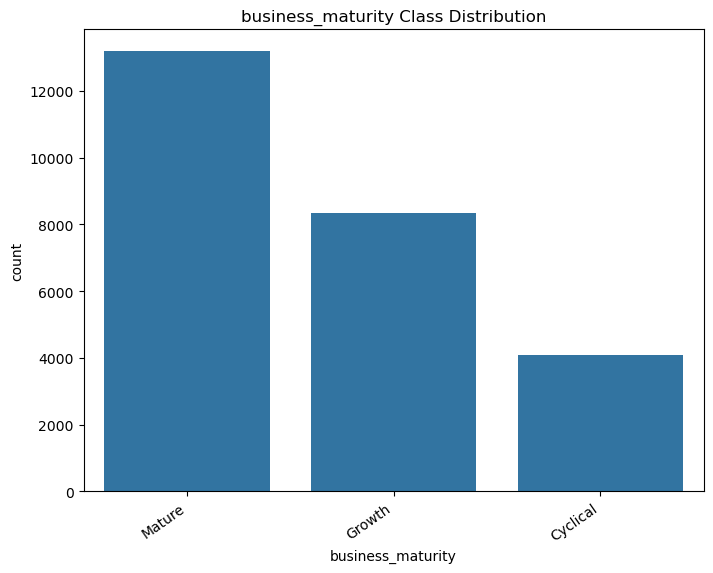

In [22]:
show_distribution_plot_categorical(df_clean, "business_maturity")

These concepts are very important when training our models later. This helps the model to also distinguish between independent attributes that do and do not assume ordering. Nevertheless, let's analyse the distribution for all attributes.

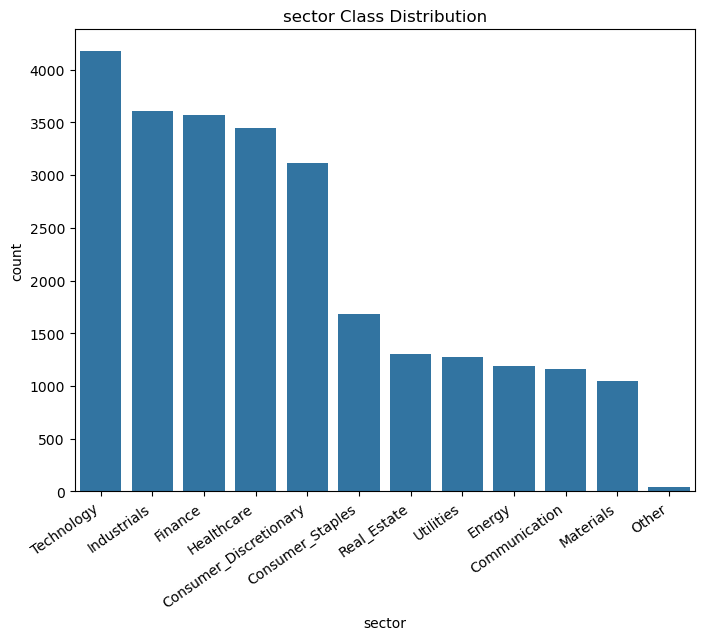

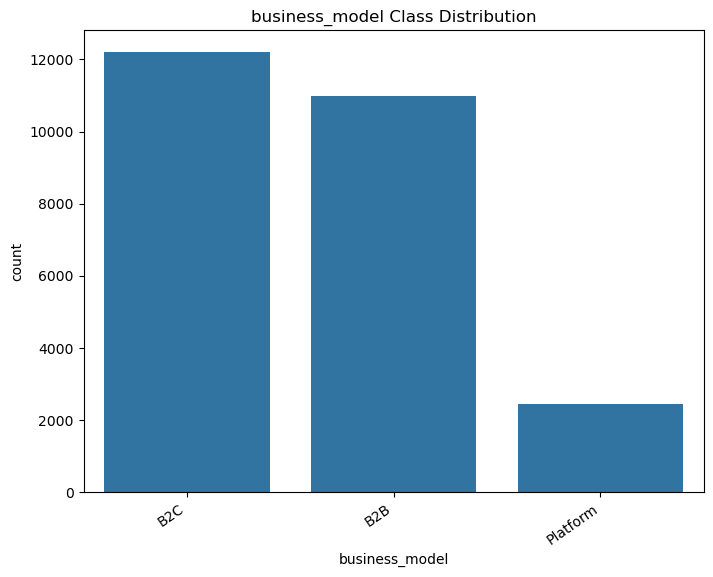

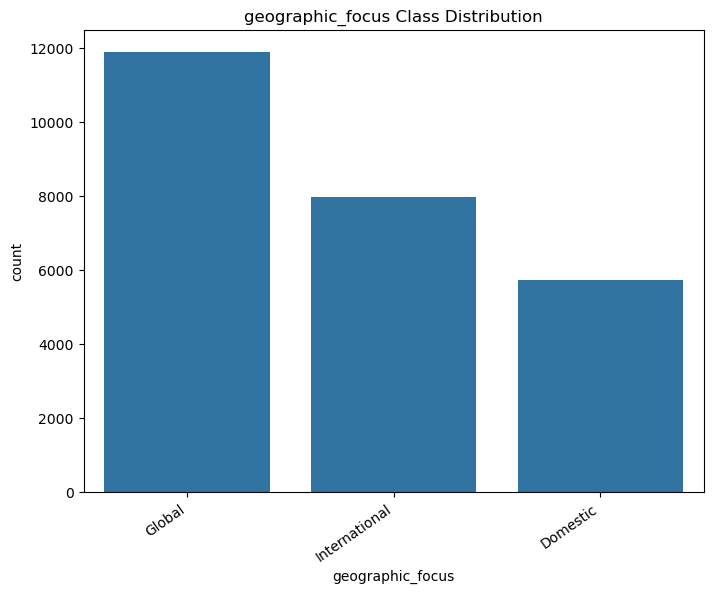

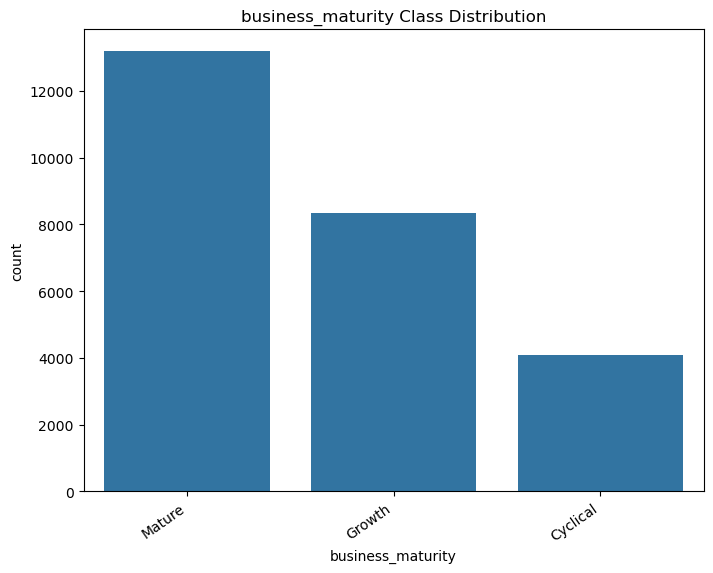

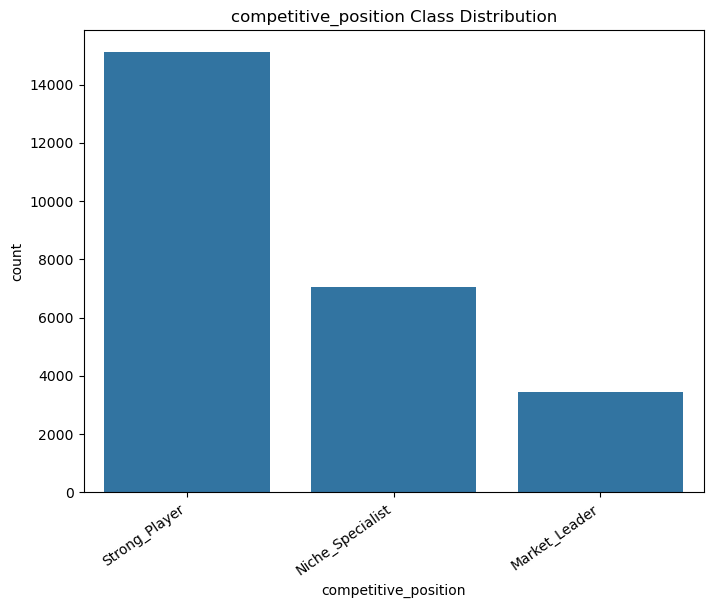

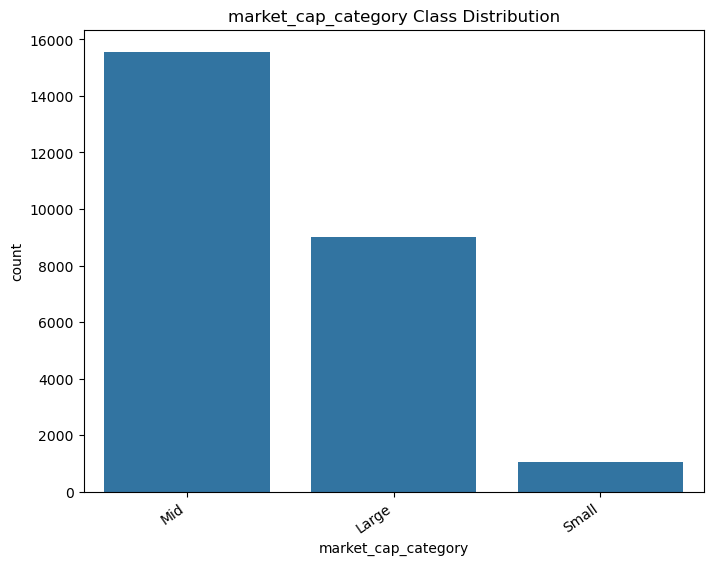

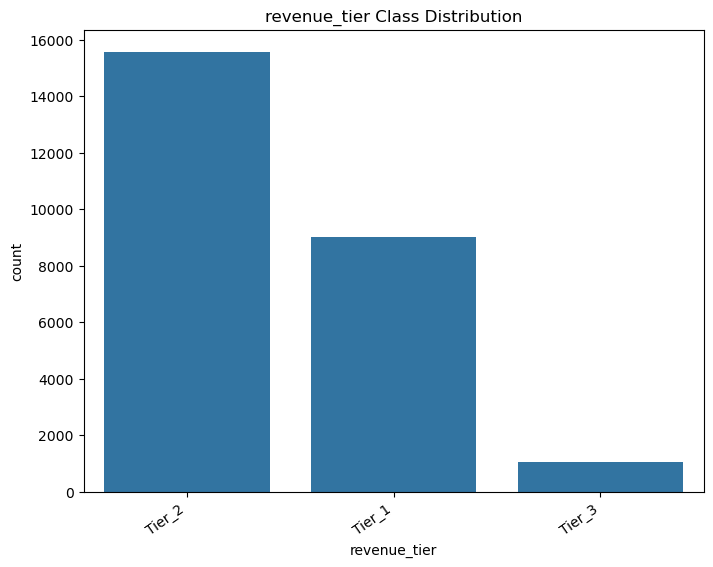

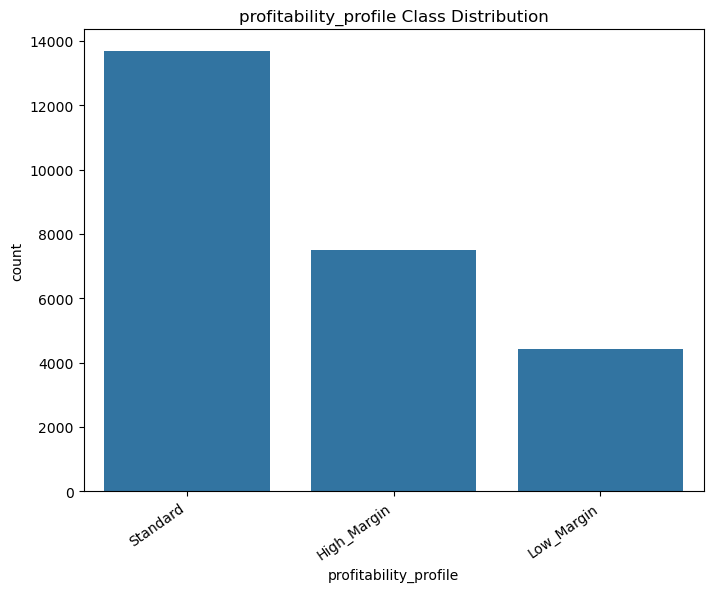

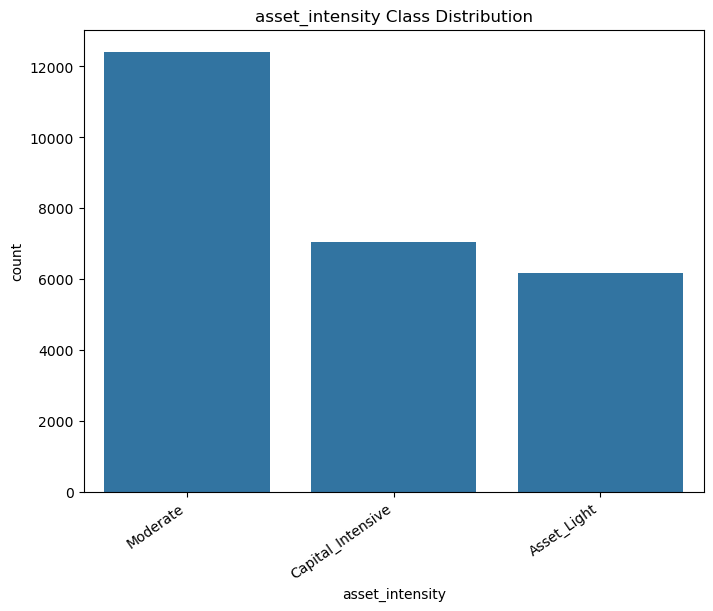

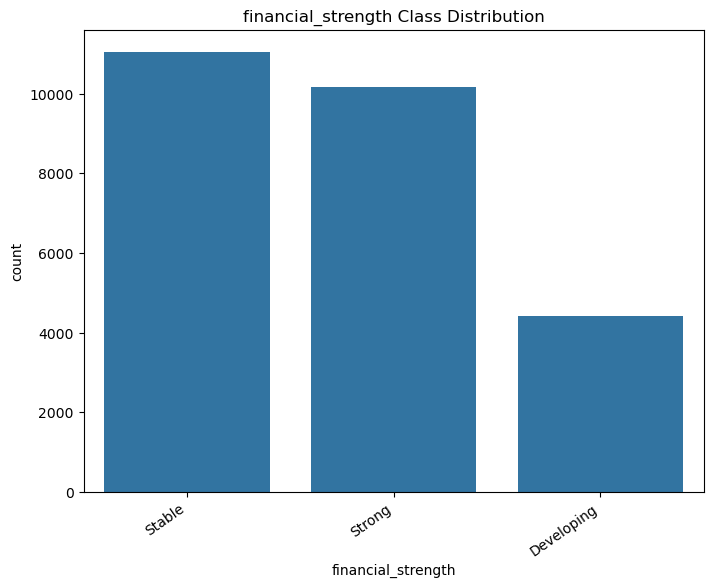

In [23]:
for categorical_feature in categorical_features:
    show_distribution_plot_categorical(df_clean, categorical_feature)

C:\Users\Archel\AppData\Local\Temp\ipykernel_34852\2709778576.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12,6))


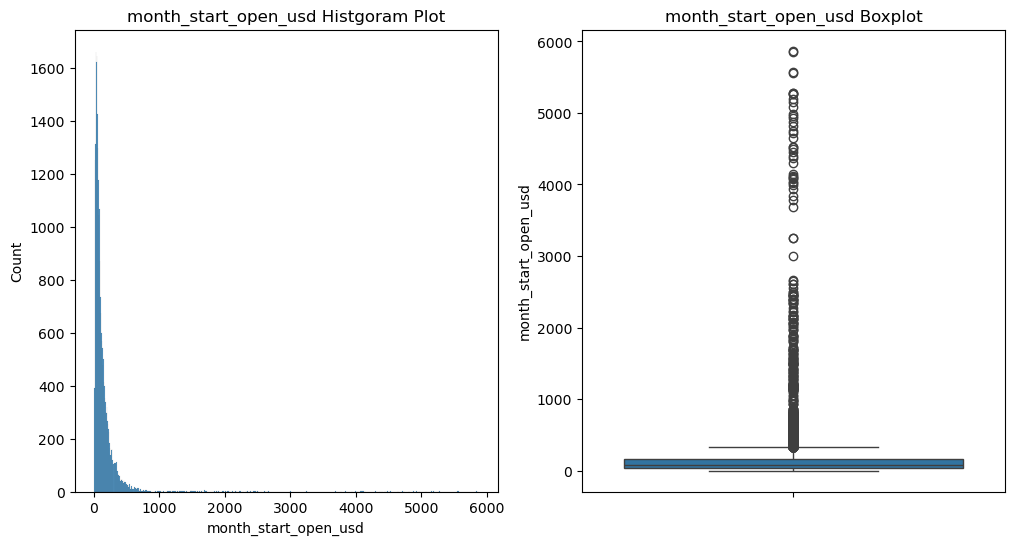

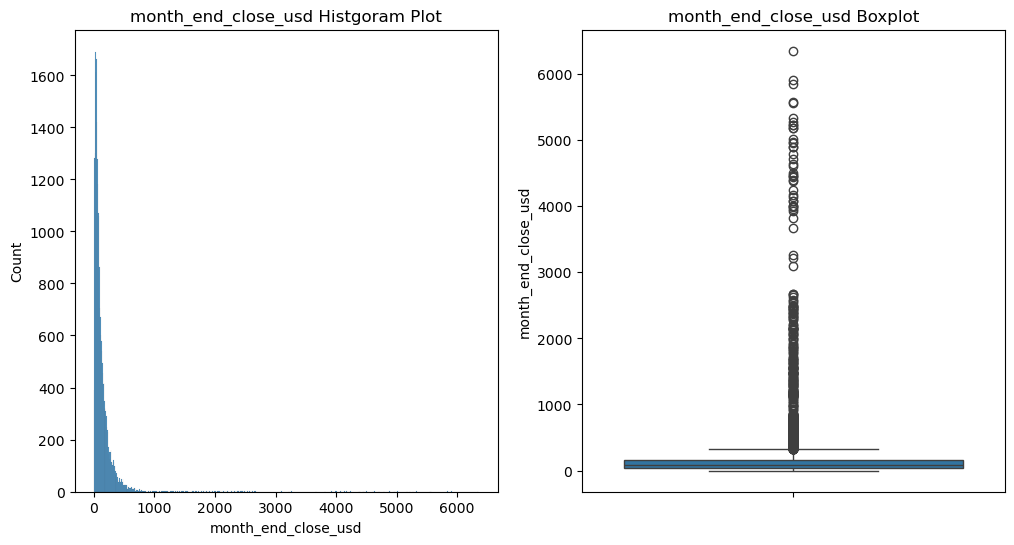

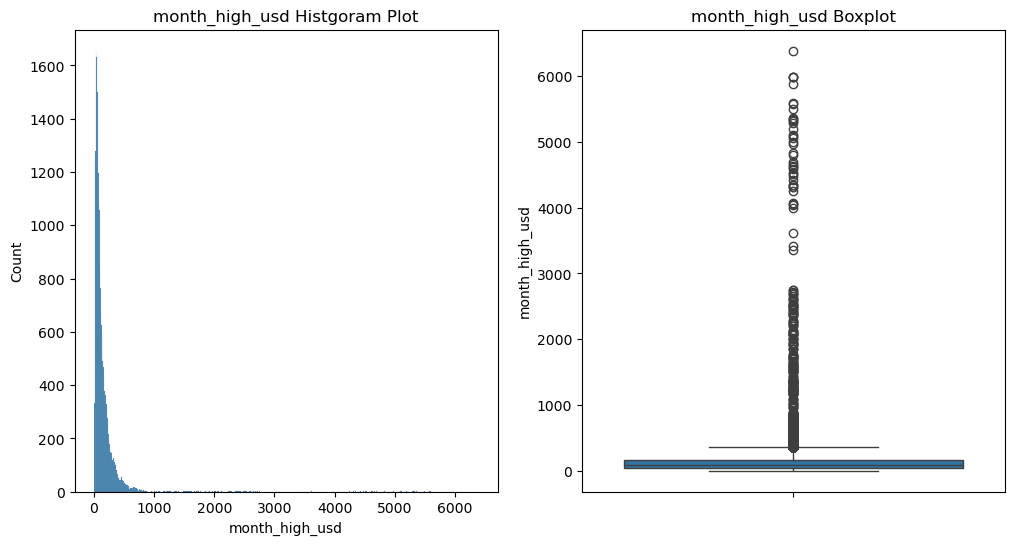

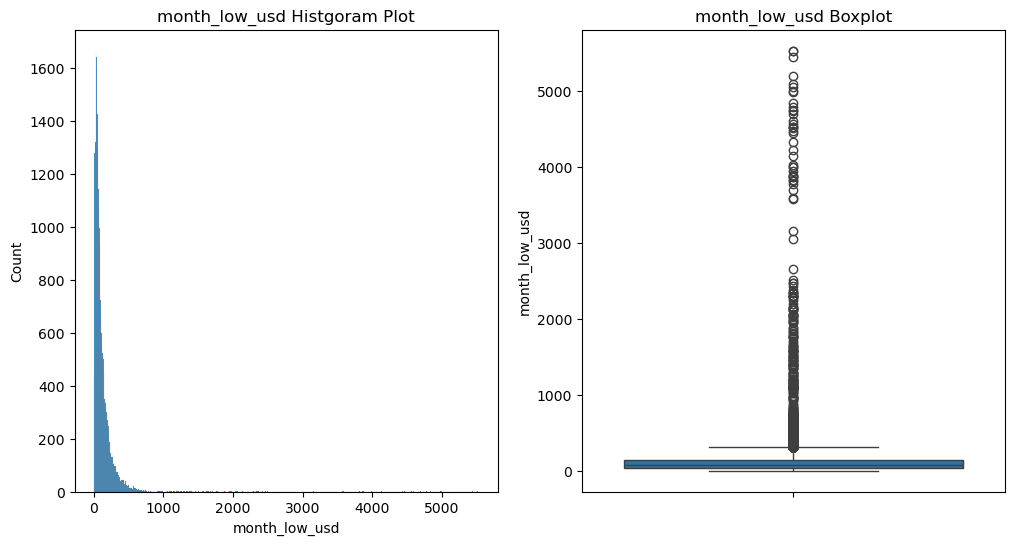

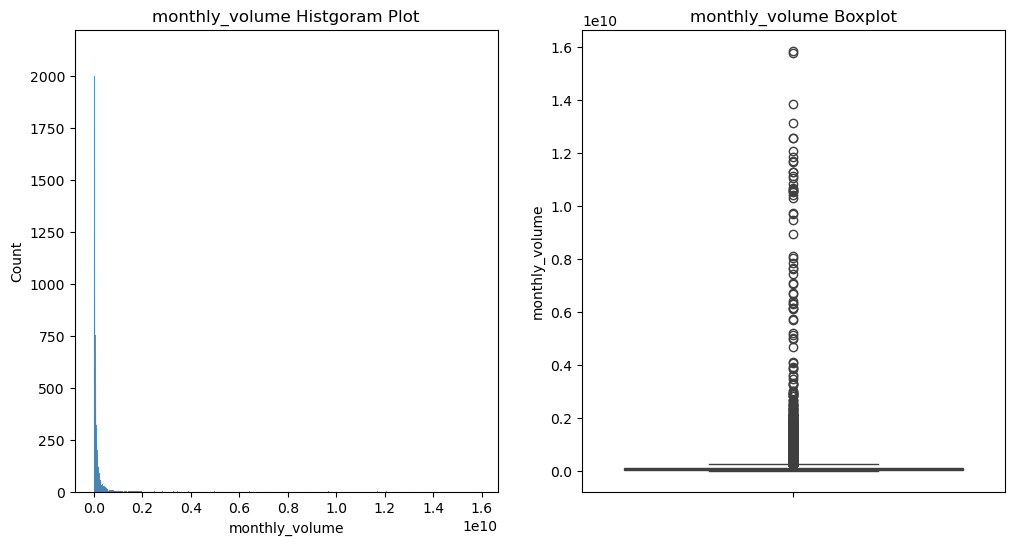

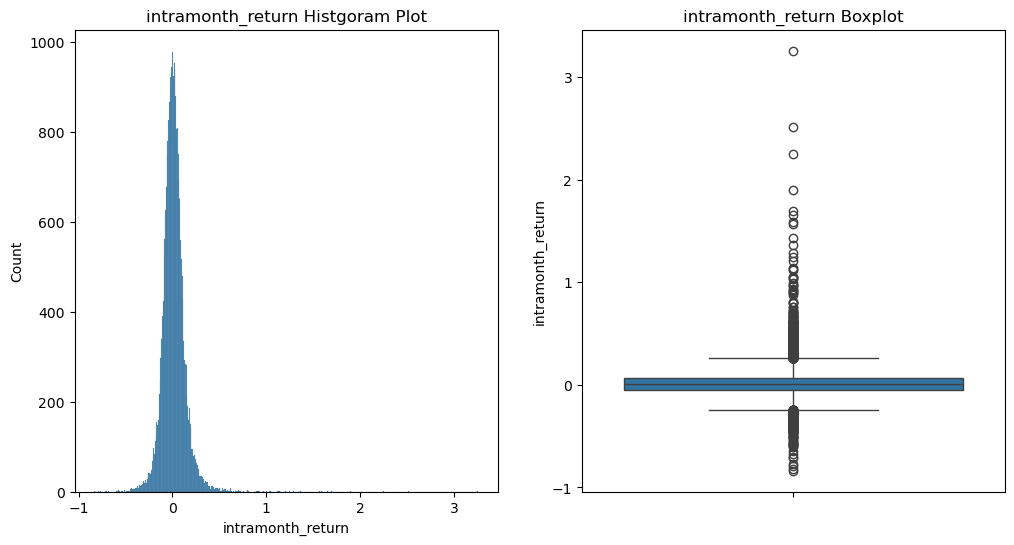

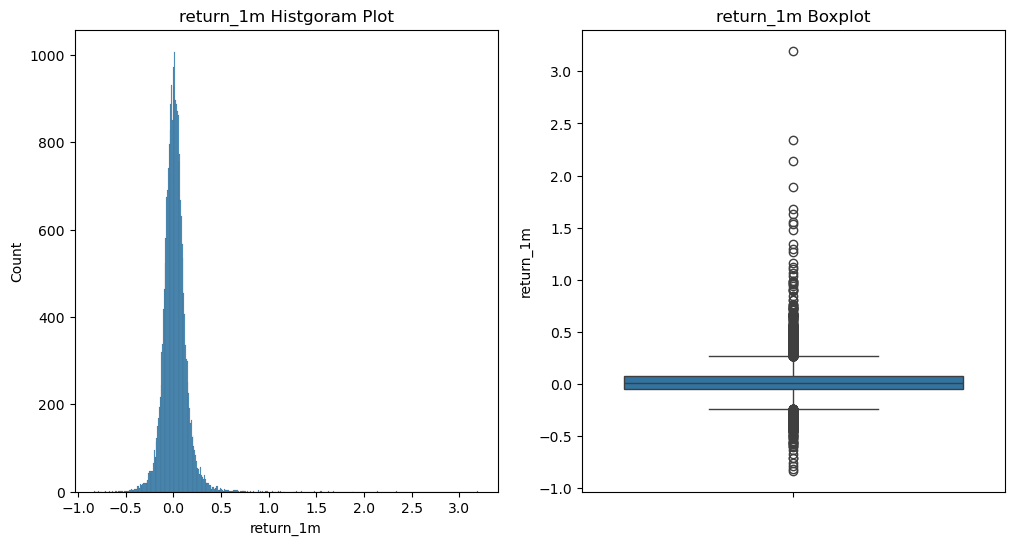

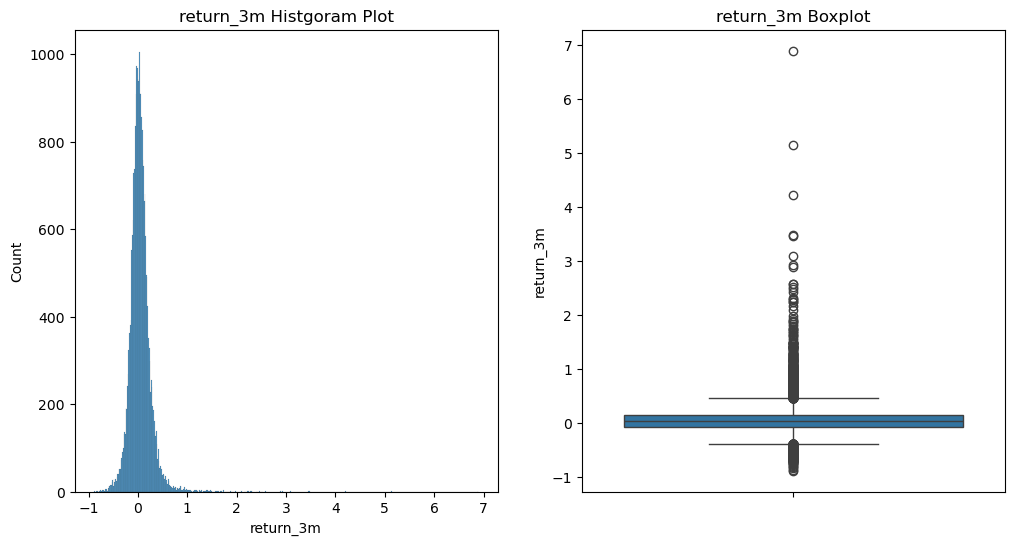

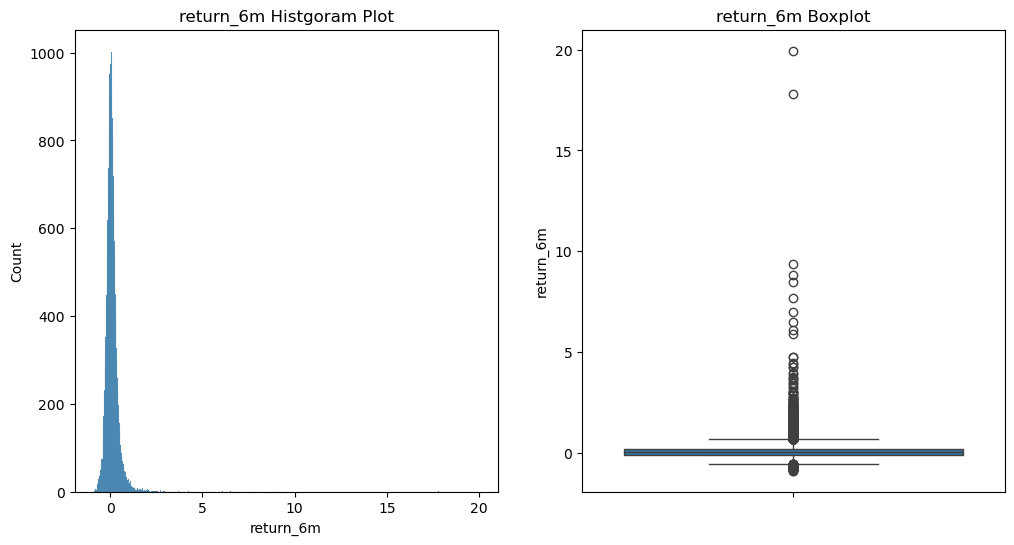

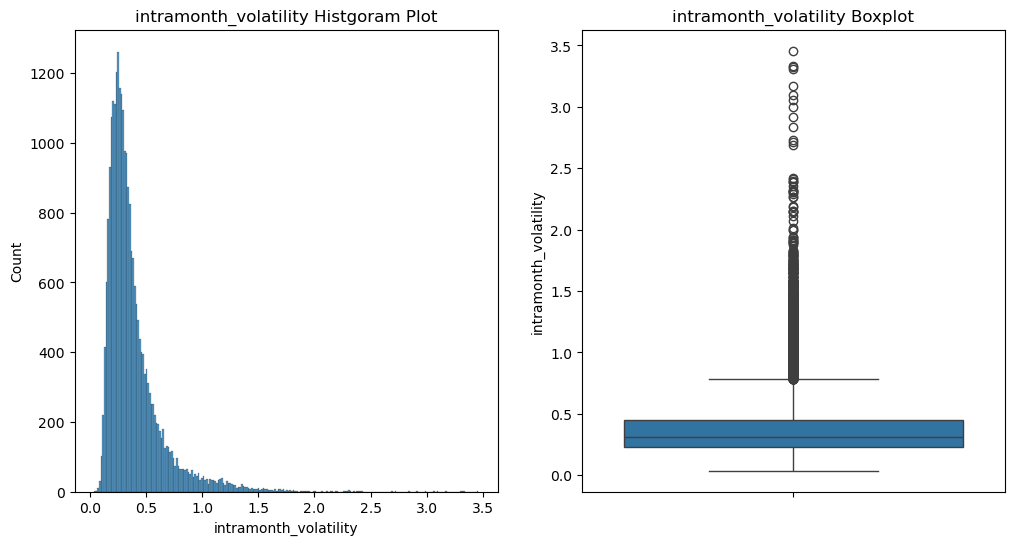

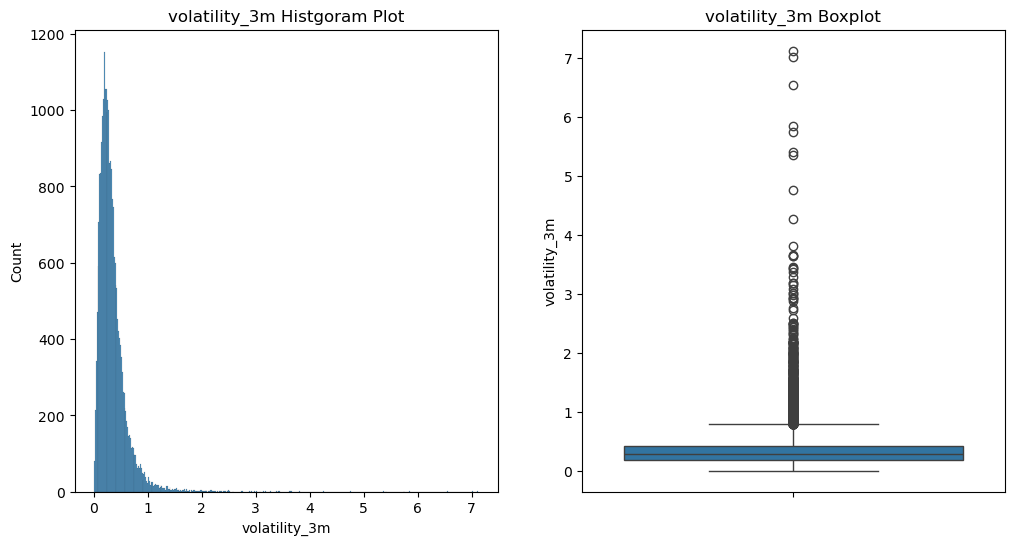

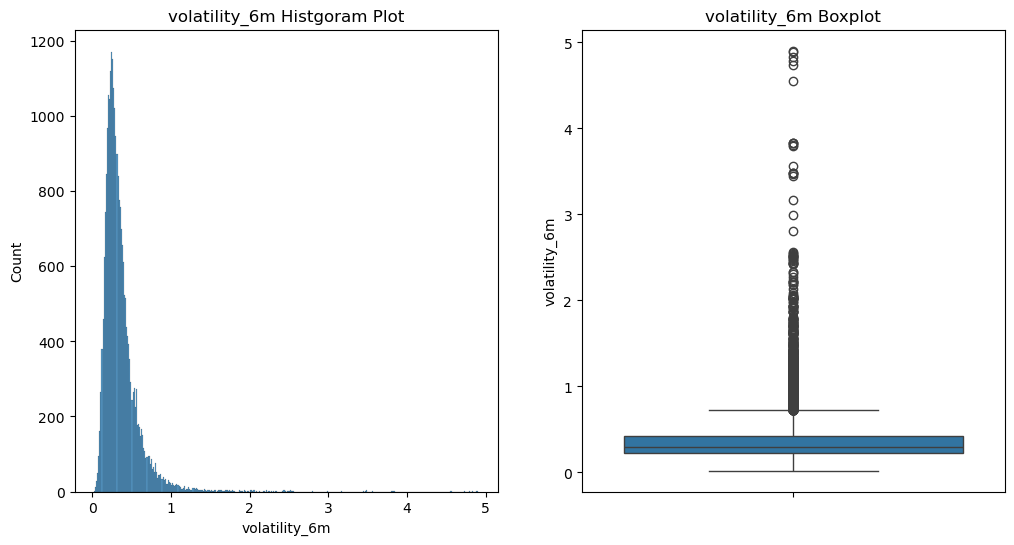

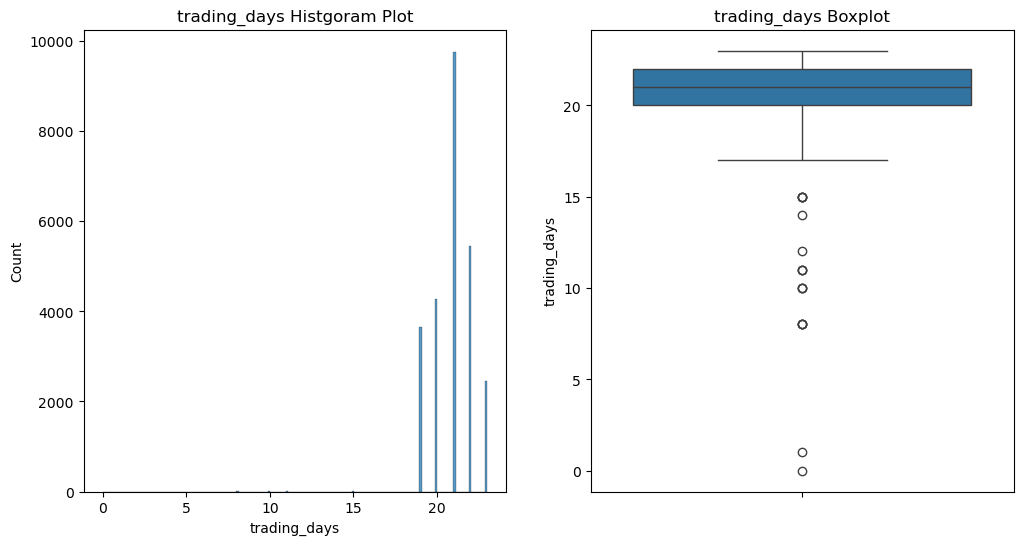

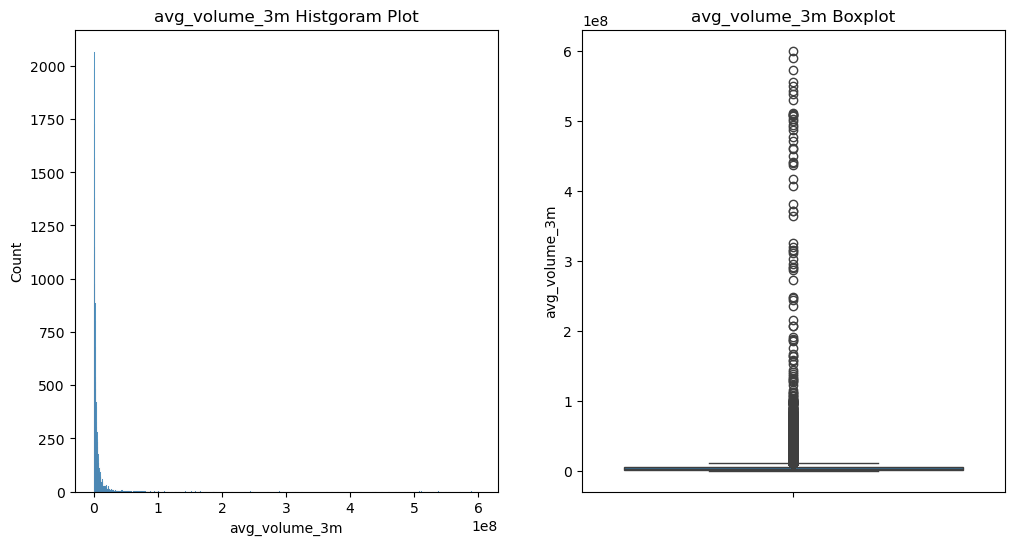

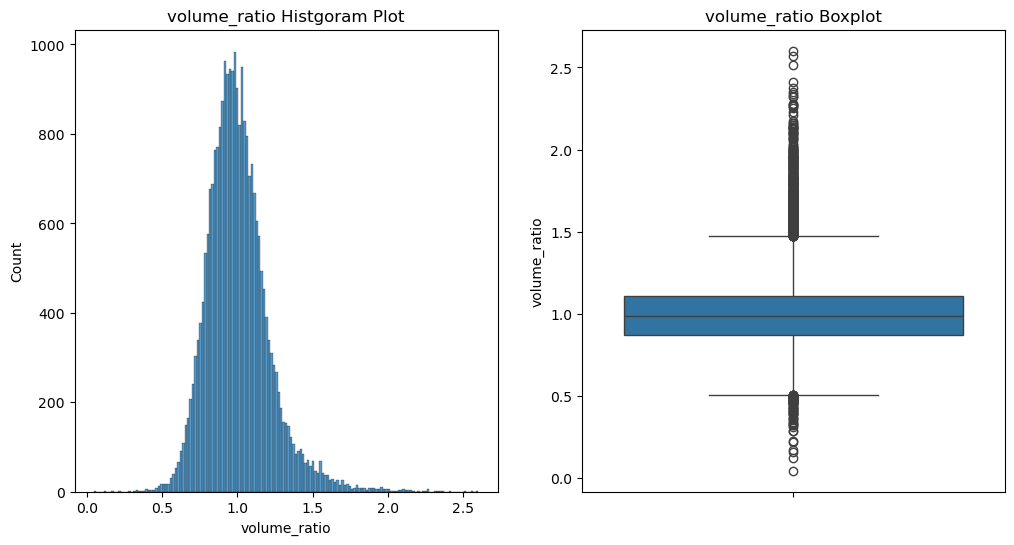

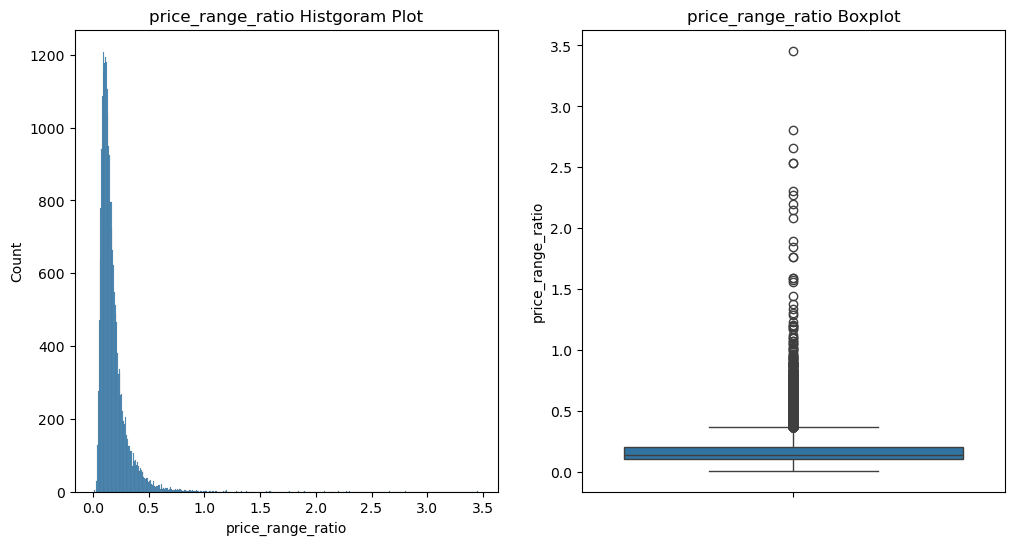

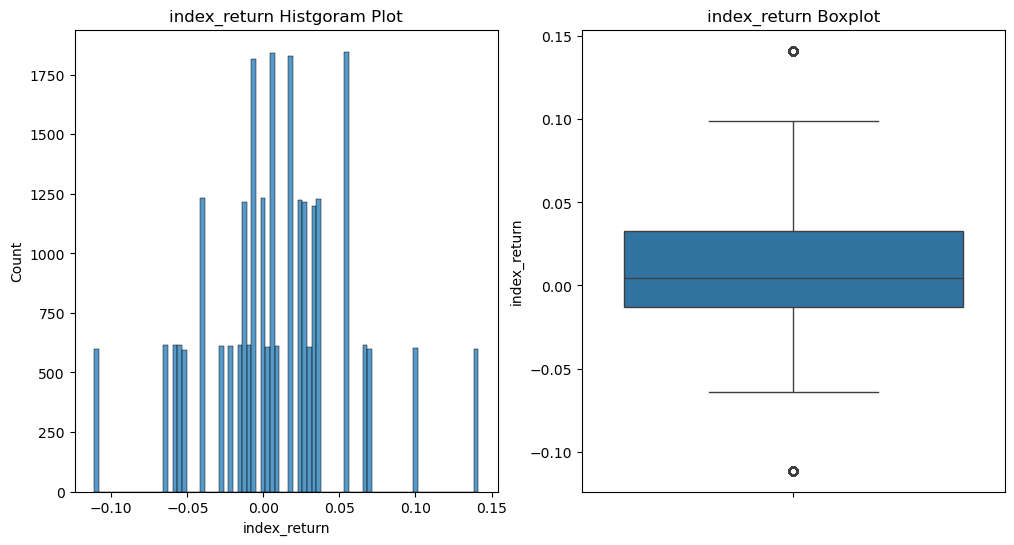

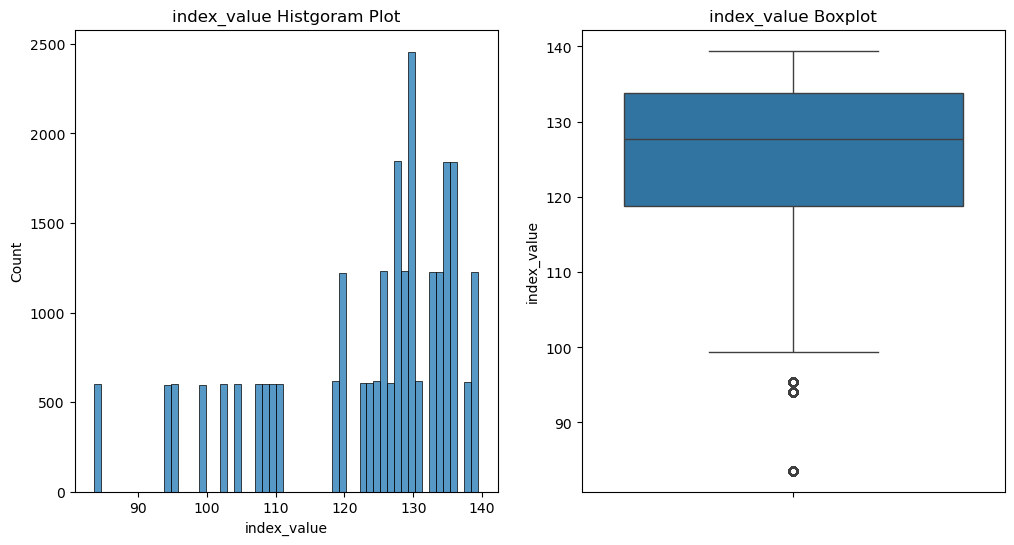

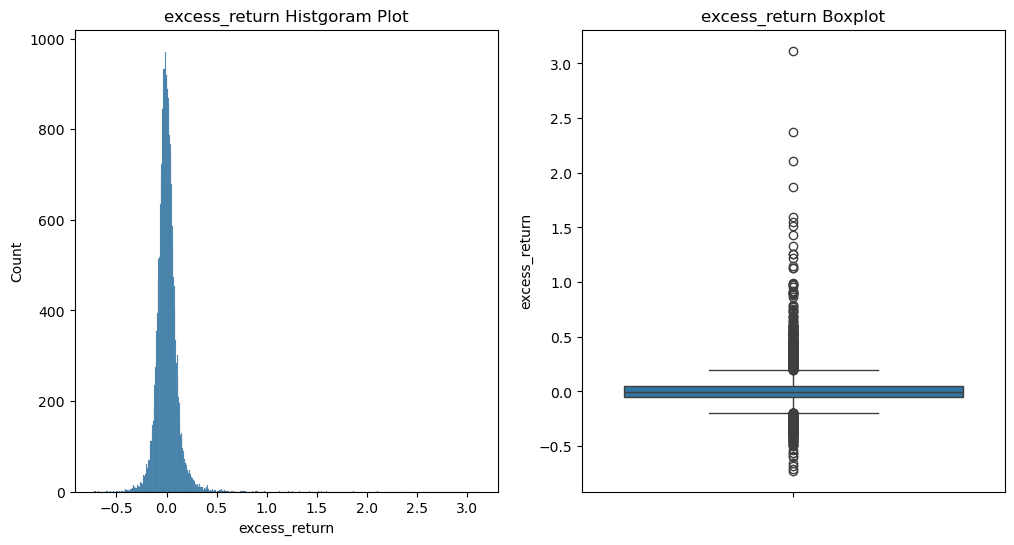

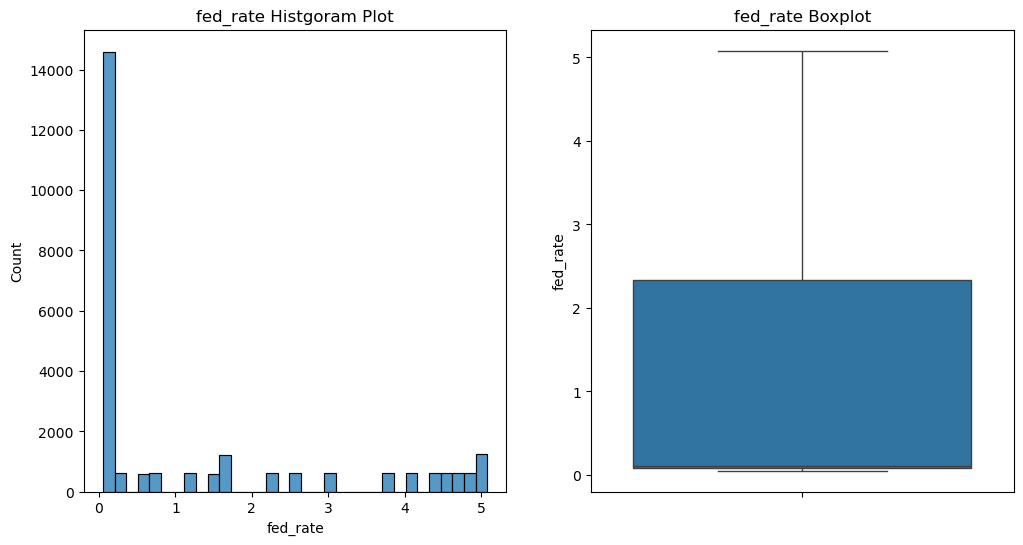

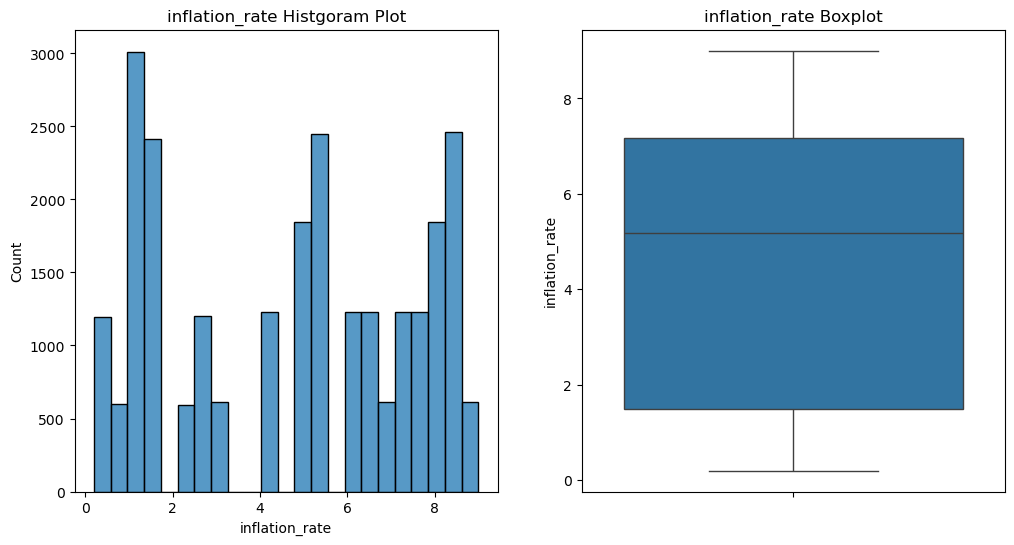

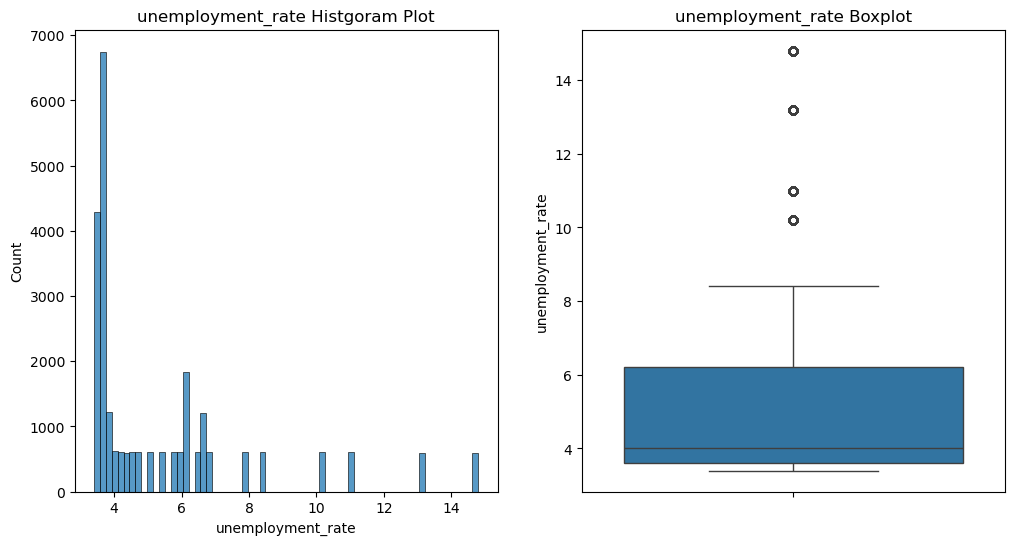

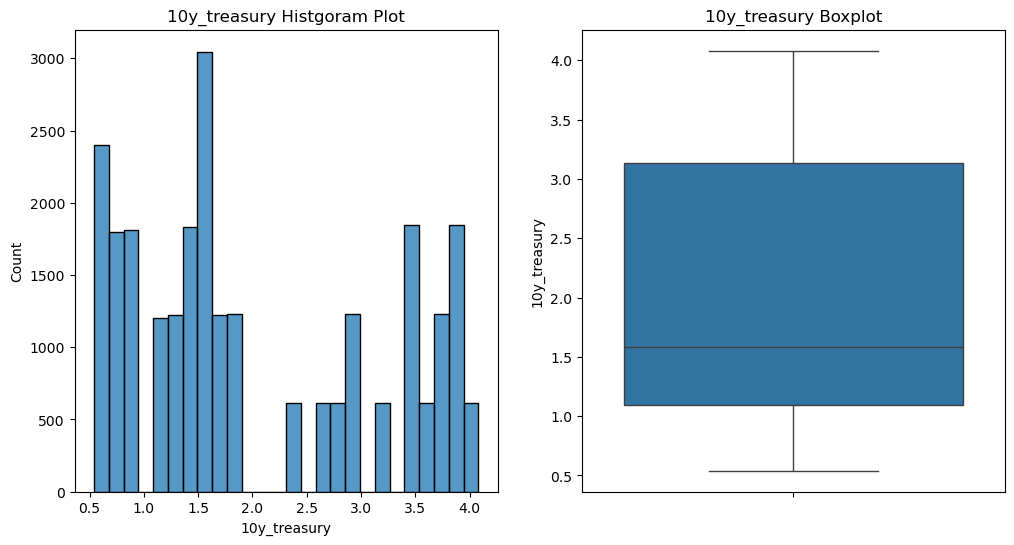

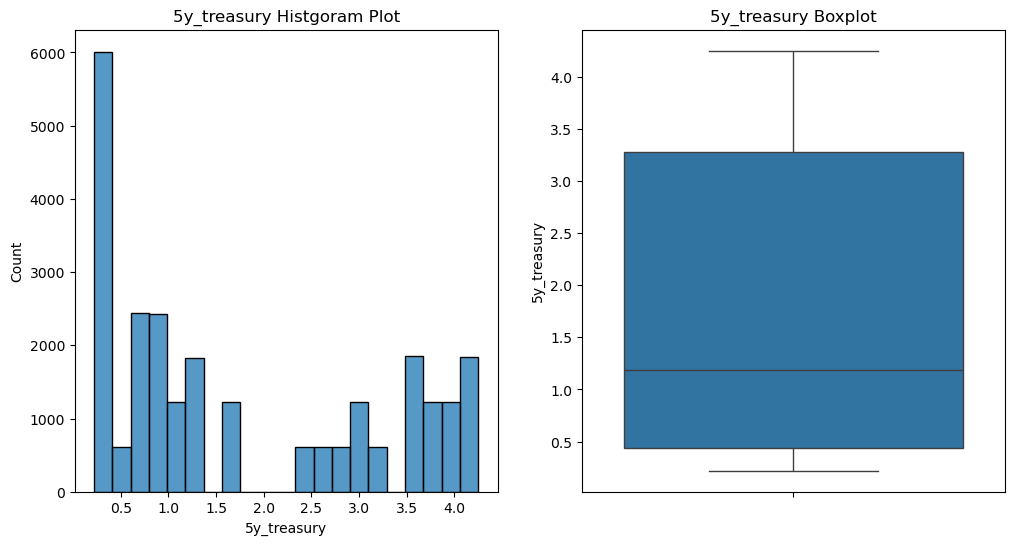

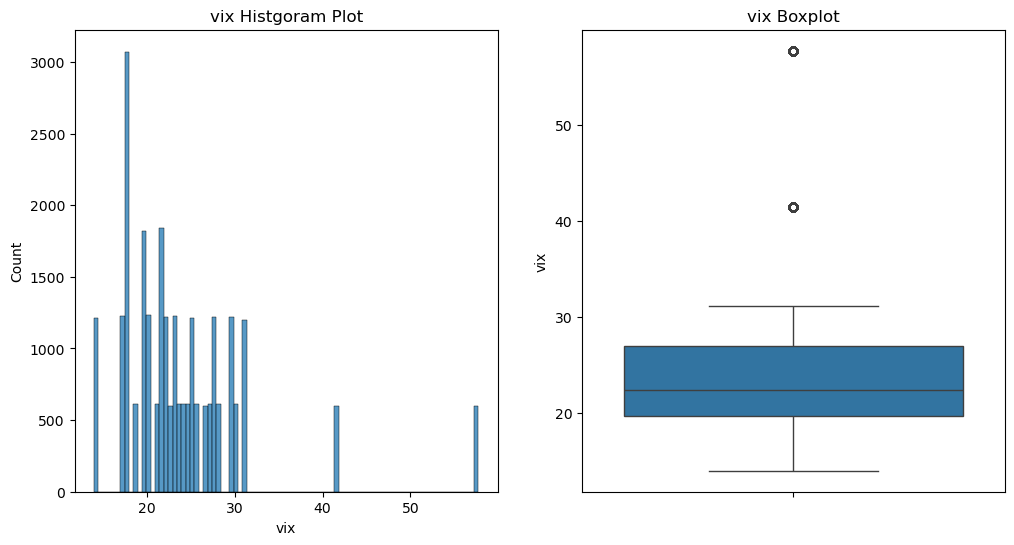

In [24]:
for numerical_feature in numerical_features:
    show_distribution_plot_numerical(df_clean, numerical_feature)

Lastly, to get the first idea on what features significantly affect the decision of the `outperform_binary` labels, we can show a correlation plot for all available features.

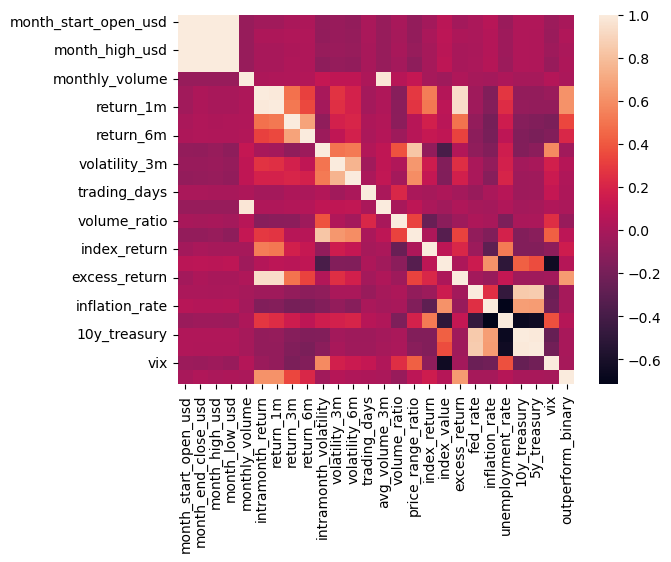

In [25]:
corr_df = df_clean[numerical_features + ["outperform_binary"]].corr()
sns.heatmap(corr_df)
plt.show()

It seems like return features `return_1m`, `return_3m`, and `return_6m` have the most influence in deciding the labels. In fact, the `excess_return` and `outperform_binary` calculation are obtained using the "monthly stock return values". Where:

```
monthly_stock_return = (month_end_close_usd - month_start_open_usd) / month_start_open_usd * 100
```

Then to calculate the excess return:

```
excess_return = monthly_stock_return - monash_index_return
```

Indeed, the return values have direct impact with the `excess_return` and `outperform_binary` labels. Let's prove this further by performing statistical tests for return attributes. We will use the Pearson's correlation and the Independent sample's t-test. Both parametric tests assume normality, meaning that the distributions for the data being tested have normal distribution as we have seen from the distribution EDA above, although only small portion of the attributes have skewed distributions.

In [26]:
def perform_stats_analysis_numerical_numerical(df, col1, col2):
    corr, p_value = pearsonr(df[col1], df[col2])
    return corr, p_value

def perform_stats_analysis_numerical_categorical(df, col1, col2):
    t_stat, p_val = ttest_ind(df[col1], df[col2], equal_var=False)
    return t_stat, p_val


In [27]:
for col in numerical_features:
    if col == "excess_return":
        continue
    
    corr, p_value = perform_stats_analysis_numerical_numerical(df_clean, "excess_return", col)
    if p_value < 0.05:
        print(f"Pearson correlation between {col} and excess_return:", corr, "p-value:", p_value)
    else:
        print(f"{col} is not statistically significant to excess_return")

Pearson correlation between month_start_open_usd and excess_return: -0.02255164259101154 p-value: 0.00030641660982278683
Pearson correlation between month_end_close_usd and excess_return: 0.01772828473239215 p-value: 0.004545309183051161
month_high_usd is not statistically significant to excess_return
month_low_usd is not statistically significant to excess_return
Pearson correlation between monthly_volume and excess_return: 0.02772322385742227 p-value: 9.083600459840195e-06
Pearson correlation between intramonth_return and excess_return: 0.9378697930280722 p-value: 0.0
Pearson correlation between return_1m and excess_return: 0.9341153773475775 p-value: 0.0
Pearson correlation between return_3m and excess_return: 0.4934629870813125 p-value: 0.0
Pearson correlation between return_6m and excess_return: 0.3255572171836362 p-value: 0.0
Pearson correlation between intramonth_volatility and excess_return: 0.03510260167375058 p-value: 1.9112541763249292e-08
Pearson correlation between volatil

All numerical features are statistically significant except for `month_high_usd` and `month_low_usd`. This might be an early sign that perhaps we can remove them while training the model.

In [28]:
for col in numerical_features:
    if col == "excess_return":
        continue
    
    t_stat, p_value = perform_stats_analysis_numerical_categorical(df_clean, "outperform_binary", col)
    if p_value < 0.05:
        print(f"T-test correlation between {col} and outperform_binary:", t_stat, "p-value:", p_value)
    else:
        print(f"{col} is not statistically significant to excess_return")

T-test correlation between month_start_open_usd and outperform_binary: -86.71789496519054 p-value: 0.0
T-test correlation between month_end_close_usd and outperform_binary: -86.3935520412571 p-value: 0.0
T-test correlation between month_high_usd and outperform_binary: -87.39244365107334 p-value: 0.0
T-test correlation between month_low_usd and outperform_binary: -85.77232497668412 p-value: 0.0
T-test correlation between monthly_volume and outperform_binary: -42.29483167292131 p-value: 0.0
T-test correlation between intramonth_return and outperform_binary: 148.26980080237473 p-value: 0.0
T-test correlation between return_1m and outperform_binary: 147.59138981681528 p-value: 0.0
T-test correlation between return_3m and outperform_binary: 130.71705051040107 p-value: 0.0
T-test correlation between return_6m and outperform_binary: 99.2256243721257 p-value: 0.0
T-test correlation between intramonth_volatility and outperform_binary: 30.174009713789076 p-value: 1.137667414580904e-197
T-test co

This time however, all features are statistically significant to `outperform_binary` label. We just discovered how the two tests contradict each other. Thus, we cannot draw any conclusions from both statistical tests and graphs alone. We will still keep all features when training the models.



## Feature Engineering

In a time series problem like this, the values in `stock_data.csv` are only available up to June 2023 (`2023_06`). To predict labels such as `outperform_binary` for July 2023 (`2023_07`), we would need that month’s features (returns, volatility, volumes, fundamentals, etc.).

The problem is, we won’t actually know those future values yet. If the model had access to them during training, it would be "peeking" into the future, essentially cheating since it would already know the real price values we are trying to forecast.

To solve this, we create proxy features that rely only on information available at or before the prediction month. These are the strategies we adopt:

1. **Static company features**

- Characteristics that don’t change frequently, or at all (e.g., sector, business model, market cap category, maturity, revenue tier).
- Derived from `company_info.csv`.

2. **Rolling / lagged historical features**

- Instead of using future values directly, we compute aggregates (mean, median, std, sum, etc.) over past time windows (e.g., 3M, 6M, 12M).
- Example: when predicting `2023_01`, instead of plugging in that month’s `return_3m` (which we don’t know yet), we calculate rolling averages or medians of past returns up to December 2022.

3. **Handling missing values at the start of the series**

- At the beginning of the dataset (e.g., January 2020), rolling or lagged values aren’t available because there’s no prior data.
- These early months produce some NaN values. Since they represent only a small portion of the data, we can handle them with simple forward-fill or backward-fill strategies since we have performed our missing values EDA where forward/backward fill is more favorable compared to a static values like mean or median.

In [29]:
def impute_missing_columns(df, imputation_method):    
    for column in df.columns:
        if column in ["month_id", "stock_id"]:  # never impute ID columns
            continue
        
        if imputation_method == "ffill":
            df[column] = df[column].fillna(method="ffill")
        elif imputation_method == "median":
            df[column] = df[column].fillna(df[column].median())
    
    return df

def compute_rolling_statistic_features(df, macro_cols):
    grouped = df.groupby('stock_id')

    # Price-based returns 
    for window in [3, 6, 12]:
        df[f'intramonth_return_rolling_mean_{window}m']   = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'intramonth_return_rolling_std_{window}m']    = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).std())
        df[f'intramonth_return_rolling_median_{window}m'] = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).median())

    # Lagged returns 
    for col in ['return_1m', 'return_3m', 'return_6m']:
        for lag in [1, 2]:
            df[f'{col}_lagged_{lag}'] = grouped[col].shift(lag)

    # Volatility features
    for col, windows in [
        ('intramonth_volatility', [3, 6, 12]),
        ('volatility_3m', [3, 6]),
        ('volatility_6m', [3, 6])
    ]:
        for window in windows:
            df[f'{col}_rolling_mean_{window}m'] = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
            df[f'{col}_rolling_std_{window}m']  = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).std())

    # Volume features
    for col, windows in [
        ('monthly_volume', [3, 6]),
        ('avg_volume_3m', [3, 6]),
        ('volume_ratio', [3, 6])
    ]:
        for window in windows:
            df[f'{col}_rolling_mean_{window}m'] = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
            df[f'{col}_rolling_sum_{window}m']  = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).sum())

    # Price range
    df['price_range'] = df['month_high_usd'] - df['month_low_usd']
    for window in [3, 6, 12]:
        df[f'price_range_rolling_mean_{window}m']       = grouped['price_range'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'price_range_ratio_rolling_mean_{window}m'] = grouped['price_range_ratio'].transform(lambda x: x.rolling(window, min_periods=1).mean())

    # Index rolling features
    for window in [3, 6]:
        df[f'index_return_rolling_mean_{window}m'] = grouped['index_return'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'index_return_rolling_std_{window}m']  = grouped['index_return'].transform(lambda x: x.rolling(window, min_periods=1).std())

    # Additional features
    if macro_cols:
        for col in macro_cols:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_mean_{window}m'] = df.groupby('month_id')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
                df[f'{col}_rolling_std_{window}m']  = df.groupby('month_id')[col].transform(lambda x: x.rolling(window, min_periods=1).std())

    return df
    
def handle_missing_rolling_features(df, strategy="drop", fill_value=0):
    rolling_cols = [c for c in df.columns if "lag" in c or "rolling" in c]
    if strategy == "drop":
        df = df.dropna(subset=rolling_cols)
    elif strategy == "fill":
        df[rolling_cols] = df[rolling_cols].fillna(fill_value)
    elif strategy == "ffill":
        df[rolling_cols] = df[rolling_cols].fillna(method="ffill")
    elif strategy == "bfill":
        df[rolling_cols] = df[rolling_cols].fillna(method="bfill")

    return df

def build_training_data(df, imputation_method, macro_cols=None,
                        build_additional_features=False, handle_missing_rolling_features_strategy="bfill"):
    train_df = df.copy()
    train_df = impute_missing_columns(train_df, imputation_method=imputation_method)
    train_df = train_df.sort_values(by=["stock_id", "month_id"])
    
    if build_additional_features:
        train_df = compute_rolling_statistic_features(train_df, macro_cols)
        train_df = handle_missing_rolling_features(train_df, strategy=handle_missing_rolling_features_strategy)
    
    train_df["outperform_binary"] = df["outperform_binary"]
    train_df["excess_return"] = df["excess_return"]
    
    return train_df

In [30]:
df_feature_engineering = build_training_data(df_without_optional_features, imputation_method="ffill",
                                            macro_cols=None, 
                                            build_additional_features=True,
                                            handle_missing_rolling_features_strategy="bfill")
df_feature_engineering.head()

C:\Users\Archel\AppData\Local\Temp\ipykernel_34852\3088241577.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")
C:\Users\Archel\AppData\Local\Temp\ipykernel_34852\3088241577.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[rolling_cols] = df[rolling_cols].fillna(method="bfill")


,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,price_range_rolling_mean_3m,price_range_ratio_rolling_mean_3m,price_range_rolling_mean_6m,price_range_ratio_rolling_mean_6m,price_range_rolling_mean_12m,price_range_ratio_rolling_mean_12m,index_return_rolling_mean_3m,index_return_rolling_std_3m,index_return_rolling_mean_6m,index_return_rolling_std_6m
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,...,16.451000,0.136875,16.451000,0.136875,16.451000,0.136875,-0.006452,0.032953,-0.006452,0.032953
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,...,14.228000,0.123890,14.228000,0.123890,14.228000,0.123890,-0.029753,0.032953,-0.029753,0.032953
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,...,18.745667,0.172237,18.745667,0.172237,18.745667,0.172237,-0.056962,0.052573,-0.056962,0.052573
3,US001,2020_04,90.100,103.697,111.314,89.424,98448862,0.150910,0.112885,-0.033810,...,20.558667,0.207597,19.531750,0.189916,19.531750,0.189916,-0.007707,0.132309,-0.007393,0.108031
4,US001,2020_05,101.909,107.841,110.206,89.499,103380207,0.058209,0.039966,0.058641,...,23.459333,0.238357,19.766800,0.192570,19.766800,0.192570,0.033722,0.130455,0.008332,0.099947


In [31]:
df_feature_engineering.shape

(25618, 84)

Once we have built the necessary features, we can drop the remaining features from the original data.

In [32]:
cols_to_drop = [col for col in df_without_optional_features.columns if col not in ["excess_return", "outperform_binary"]]
df_feature_engineering = df_feature_engineering.drop(cols_to_drop, axis=1)
df_feature_engineering.shape

(25618, 54)

In [33]:
categorical_features = [column for column in df_feature_engineering.columns if df_feature_engineering[column].dtype == "O" and column not in ["stock_id", "month_id"]]
numerical_features = [column for column in df_feature_engineering.columns if df_feature_engineering[column].dtype == "float64" or df_feature_engineering[column].dtype == "int64" and column not in ["outperform_binary", "excess_return"]]

In [34]:
for col in numerical_features:
    if col == "excess_return":
        continue
    
    corr, p_value = perform_stats_analysis_numerical_numerical(df_feature_engineering, "excess_return", col)
    if p_value < 0.05:
        print(f"Pearson correlation between {col} and excess_return:", corr, "p-value:", p_value)
    else:
        print(f"{col} is not statistically significant to excess_return")

Pearson correlation between intramonth_return_rolling_mean_3m and excess_return: 0.5698891362299305 p-value: 0.0
Pearson correlation between intramonth_return_rolling_std_3m and excess_return: 0.26348127541501987 p-value: 0.0
Pearson correlation between intramonth_return_rolling_median_3m and excess_return: 0.4473999000204154 p-value: 0.0
Pearson correlation between intramonth_return_rolling_mean_6m and excess_return: 0.4610386582847023 p-value: 0.0
Pearson correlation between intramonth_return_rolling_std_6m and excess_return: 0.2079224012497168 p-value: 3.568354564132065e-248
Pearson correlation between intramonth_return_rolling_median_6m and excess_return: 0.37514608345487016 p-value: 0.0
Pearson correlation between intramonth_return_rolling_mean_12m and excess_return: 0.3987216503788767 p-value: 0.0
Pearson correlation between intramonth_return_rolling_std_12m and excess_return: 0.20928958109618814 p-value: 1.7077861728207522e-251
Pearson correlation between intramonth_return_rolli

In [35]:
for col in numerical_features:
    if col == "excess_return":
        continue
    
    t_stat, p_value = perform_stats_analysis_numerical_categorical(df_feature_engineering, "outperform_binary", col)
    if p_value < 0.05:
        print(f"T-test correlation between {col} and outperform_binary:", t_stat, "p-value:", p_value)
    else:
        print(f"{col} is not statistically significant to excess_return")

T-test correlation between intramonth_return_rolling_mean_3m and outperform_binary: 151.85752706165525 p-value: 0.0
T-test correlation between intramonth_return_rolling_std_3m and outperform_binary: 124.10486094966579 p-value: 0.0
T-test correlation between intramonth_return_rolling_median_3m and outperform_binary: 153.2214888523758 p-value: 0.0
T-test correlation between intramonth_return_rolling_mean_6m and outperform_binary: 152.88229973075843 p-value: 0.0
T-test correlation between intramonth_return_rolling_std_6m and outperform_binary: 122.10438175464961 p-value: 0.0
T-test correlation between intramonth_return_rolling_median_6m and outperform_binary: 154.80072865819204 p-value: 0.0
T-test correlation between intramonth_return_rolling_mean_12m and outperform_binary: 153.30992061606887 p-value: 0.0
T-test correlation between intramonth_return_rolling_std_12m and outperform_binary: 119.74497465527323 p-value: 0.0
T-test correlation between intramonth_return_rolling_median_12m and ou

Both tests produced conflicting results in identifying statistically significant features with respect to the labels. Nevertheless, the majority of lagged and rolling features were found to be statistically significant. This is a positive outcome, as it allows us to use these features as inputs for our experiments and refine them further during the feature selection stage.

Next, we will build our models in the `modelling_experiment.ipynb` notebook.